# GANS/Cyclic GANS For Data Augmentation and Neural Style Transfer

In [1]:
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt

# Model class
from tensorflow.keras.models import Model

# Layers
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPool2D

# Optimizer
from tensorflow.keras.optimizers import Adam

# Loss function
from tensorflow.keras.losses import BinaryCrossentropy

# Data loader
from tensorflow.keras.utils import Sequence

# Metrics
from tensorflow.keras.metrics import BinaryAccuracy, Recall

# ImageLoader
from skimage.io import imread

# Dataset
import tensorflow_datasets as tfds 

# Progress Bar
from tensorflow.keras.utils import Progbar

## Getting The Data

## Pre-Processing The Data

In [2]:
# create a dataloader iterator that loads data from directory
# batch data
# resize to all the same size
# split train test
# normalize (min-max)

In [3]:
class DataLoader(Sequence):
    
    def __init__(self, image_dir, batch_size, resize= None, classification= True, training= True):
        
        self.image_dir = image_dir
        self.classification = classification
        self.training = training
        
        self.images_dirs = glob.glob(f"{self.image_dir}/*.png")
    
    def __len__(self):
        return 
    
    def __getitem__(self, index):
        return
    
    def add_data(self, batched_data):
        return

Show a bit more of the data

## Define Metrics For Classification
- Accuracy
- Precision
- Recall

## Building The Classifier

In [120]:
class Classifier(Model):
    
    def __init__(self, name):
        super(Classifier, self).__init__(name= name)
        
    def build(self, input_shape):
        
        self.conv1 = Conv2D(filters= 50, kernel_size= 3, activation= 'relu', padding= 'same', kernel_initializer= 'glorot_uniform', input_shape= input_shape)
        self.maxpool1 = MaxPool2D(pool_size= (2, 2))
        
        self.conv2 = Conv2D(filters= 20, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool2 = MaxPool2D(pool_size= (2, 2))
        
        self.conv3 = Conv2D(filters= 5, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool3 = MaxPool2D(pool_size= (2, 2))
        
        self.flatten = Flatten()
        self.dense1 = Dense(units= 50, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense2 = Dense(units= 20, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense3 = Dense(units= 1, activation= 'sigmoid', kernel_initializer= 'glorot_uniform')
        
        super(Classifier, self).build(input_shape)
    
    def call(self, input_):
        x = self.conv1(input_)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.maxpool3(x)
     
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        output = self.dense3(x)
        return output
    
    def train_step(self, train_batch):
        X_train, y_train = train_batch
        
        with tf.GradientTape() as tape:
            # apply forward pass
            y_pred = self(X_train, training= True)
            loss = self.compiled_loss(y_train, y_pred, regularization_losses= self.losses)
        # calculate gradients - uses reverse gradient autodiff
        gradients = tape.gradient(loss, self.trainable_variables)
        # backpropagate the gradients and update the weights using the compiled optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.compiled_metrics.update_state(y_train, y_pred)
        return {f"train_{metric.name}": metric.result() for metric in self.metrics}
    
    def test_step(self, test_batch):
        X_test, y_test = test_batch
        # obtain prediciton
        y_pred = self(X_test, training= False)
        
        # updates loss metric
        self.compiled_loss(y_test, y_pred)
        
        # updates metrics
        self.compiled_metrics.update_state(y_test, y_pred)
        
        return {f"{metric.name}": metric.result() for metric in self.metrics}

## Traning the Classifier

In [123]:
tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    
    cats_dogs_classifier = Classifier(name= "cvd")
    cats_dogs_classifier.build(input_shape= (None, HEIGHT, WIDTH, 3))

    cats_dogs_classifier.summary()
    cats_dogs_classifier.compile(optimizer= Adam(0.001), loss= BinaryCrossentropy(), metrics= [BinaryAccuracy(), Recall()])
    model_data = cats_dogs_classifier.fit(trainDataset, validation_data= validDataset, epochs= 10)

Model: "cvd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  905       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0       

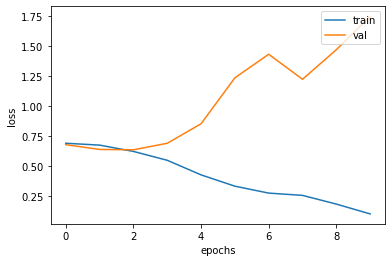

In [124]:
plt.plot(model_data.history["train_loss"])
plt.plot(model_data.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "val"], loc= "upper right")
plt.show()